## Controllability(제어 가능성)
개요 부분에 해당하며, 그래프를 만드는 여러 예제를 보여 준다.

### 하위 그래프 만드는 방법
1. 부모 + 자식 그래프 만들기
- 1.1 노드를 위한 함수, Tool, LLM, 
- 1.2 노드 구성
- 1.3 에지 연결(START, END도 구성해야 함)
- 1.4 컴파일
- 1.5 draw_mermaid_png()를 사용하여 그래프 확인
- 1.6 invoke()로 START에 데이터 입력
- 1.7 debug 옵션(초록색: 입력, 노란색: 결과)이나 랭스미스로 내용 확인 

2. 비고
- 소스 이해하기가 힘들었음(Annotated, TypedDict)
- 인터넷의 소스는 버전에 따라서 다를 수 있음
  - START = set_entry_point, END = set_finish_point 사용등

In [ ]:
%%capture --no-stderr
#%pip install -U langgraph

#### 랭스미스 연결

In [1]:
from dotenv import load_dotenv # python-dotenv
load_dotenv('../envls')
import getpass
import os

# print(os.getenv('LANGCHAIN_TRACING_V2'))
# print(os.getenv('LANGCHAIN_API_KEY'))

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
_set_env("LANGCHAIN_API_KEY")

#### 추가 라이브러리 설치
- poetry add httpx - [최신 비동기 HTTP 클라이언트](https://wikidocs.net/229723)

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

def reduce_list(left: list | None, right: list | None) -> list:
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class ChildState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]

class ParentState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]

# 자식 생성
child_builder = StateGraph(ChildState)

# chile_start 노드 추가
child_builder.add_node("child_start", lambda state: {"path": ["child_start"]})
child_builder.add_edge(START, "child_start")            # START -> child_start 연결

# chile_middle 노드 추가
child_builder.add_node("child_middle", lambda state: {"path": ["child_middle"]})

# chile_end 노드 추가
child_builder.add_node("child_end", lambda state: {"path": ["child_end"]})

child_builder.add_edge("child_start", "child_middle")   # child_start -> child_middle 연결
child_builder.add_edge("child_middle", "child_end")     # child_middle -> child_end 연결
child_builder.add_edge("child_end", END)                # child_end -> END 연결

# 부모 생성
builder = StateGraph(ParentState)

# grandparent 노드 추가
builder.add_node("grandparent", lambda state: {"path": ["grandparent"]})
builder.add_edge(START, "grandparent")                  # START -> grandparent 연결

# parent 노드 추가
builder.add_node("parent", lambda state: {"path": ["parent"]})

# child 노드 추가
builder.add_node("child", child_builder.compile()) # 자식을 통채로 추가

# sibling 노드 추가
builder.add_node("sibling", lambda state: {"path": ["sibling"]})

# fin 노드 추가
builder.add_node("fin", lambda state: {"path": ["fin"]})

# Add connections
builder.add_edge("grandparent", "parent")   # grandparent -> parent 연결
builder.add_edge("parent", "child")         # parent -> child 연결
builder.add_edge("parent", "sibling")       # parent -> sibling 연결
builder.add_edge("child", "fin")            # child -> fin 연결
builder.add_edge("sibling", "fin")          # sibling -> fin 연결
builder.add_edge("fin", END)                # fin -> END 연결

graph = builder.compile()                   # compile

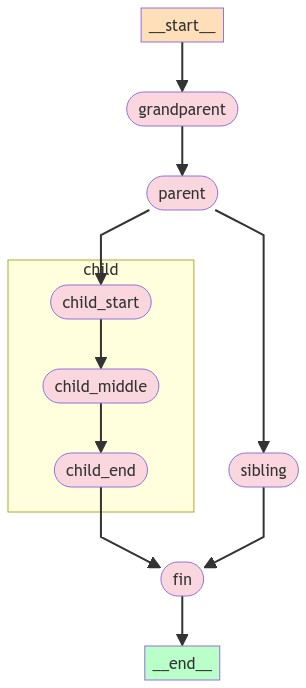

In [3]:
from IPython.display import Image, display
# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

- 문제점 ["grandparent", "parent"] 시퀀스가 ​​중복
- 자식 상태가 전체 부모 상태를 수신하고 종료되면 전체 부모 상태를 반환하기 때문

 <img src="./images/Duplicated.png" width="900">

### 상태에서 중복이나 충돌을 피하는 방법
- 함수 에서 중복을 처리(reduce)
- 파이썬 함수 내에서 자식 그래프를 호출합니다. 해당 함수에서 필요에 따라 상태를 처리합니다.
- 충돌을 피하기 위해 자식 그래프 키를 업데이트합니다. 그러나 부모가 출력을 해석할 수 있는지 확인해야 합니다.

In [4]:
graph.invoke({"name": "test"}, debug=True)

[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'name': 'test'}
[0:writes] Finished step 0 with writes to 1 channel:
- name -> 'test'
[1:tasks] Starting step 1 with 1 task:
- grandparent -> {'name': 'test', 'path': []}
[1:writes] Finished step 1 with writes to 1 channel:
- path -> ['grandparent']
[2:tasks] Starting step 2 with 1 task:
- parent -> {'name': 'test', 'path': ['grandparent']}
[2:writes] Finished step 2 with writes to 1 channel:
- path -> ['parent']
[3:tasks] Starting step 3 with 2 tasks:
- child -> {'name': 'test', 'path': ['grandparent', 'parent']}
- sibling -> {'name': 'test', 'path': ['grandparent', 'parent']}
[3:writes] Finished step 3 with writes to 2 channels:
- name -> 'test'
- path -> ['grandparent', 'parent', 'child_start', 'child_middle', 'child_end'], ['sibling']
[4:tasks] Starting step 4 with 1 task:
- fin -> {'name': 'test',
 'path': ['grandparent',
          'parent',
          'grandparent',
          'parent',
          'child_start',
          'child

{'name': 'test',
 'path': ['grandparent',
  'parent',
  'grandparent',
  'parent',
  'child_start',
  'child_middle',
  'child_end',
  'sibling',
  'fin']}

In [5]:
import uuid

def reduce_list(left: list | None, right: list | None) -> list:
    """Append the right-hand list, replacing any elements with the same id in the left-hand list."""
    if not left:
        left = []
    if not right:
        right = []
    left_, right_ = [], []
    # path에 unique한 값을 추가(중복 제거 용도)
    for orig, new in [(left, left_), (right, right_)]:
        for val in orig:
            if not isinstance(val, dict):
                val = {"val": val}
            if "id" not in val:
                val["id"] = str(uuid.uuid4())
            new.append(val)
    # Merge the two lists
    left_idx_by_id = {val["id"]: i for i, val in enumerate(left_)}
    merged = left_.copy()
    for val in right_:
        if (existing_idx := left_idx_by_id.get(val["id"])) is not None:
            merged[existing_idx] = val
        else:
            merged.append(val)
    return merged


class ChildState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]


class ParentState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]

In [6]:
child_builder = StateGraph(ChildState)

child_builder.add_node("child_start", lambda state: {"path": ["child_start"]})
child_builder.add_edge(START, "child_start")
child_builder.add_node("child_middle", lambda state: {"path": ["child_middle"]})
child_builder.add_node("child_end", lambda state: {"path": ["child_end"]})
child_builder.add_edge("child_start", "child_middle")
child_builder.add_edge("child_middle", "child_end")
child_builder.add_edge("child_end", END)

builder = StateGraph(ParentState)

builder.add_node("grandparent", lambda state: {"path": ["grandparent"]})
builder.add_edge(START, "grandparent")
builder.add_node("parent", lambda state: {"path": ["parent"]})
builder.add_node("child", child_builder.compile())
builder.add_node("sibling", lambda state: {"path": ["sibling"]})
builder.add_node("fin", lambda state: {"path": ["fin"]})

# Add connections
builder.add_edge("grandparent", "parent")
builder.add_edge("parent", "child")
builder.add_edge("parent", "sibling")
builder.add_edge("child", "fin")
builder.add_edge("sibling", "fin")
builder.add_edge("fin", END)
graph = builder.compile()

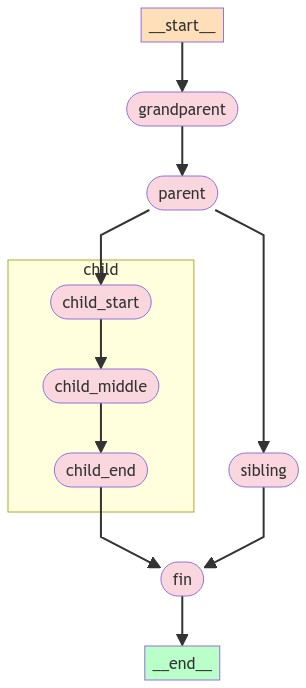

In [7]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [8]:
graph.invoke({"name": "test"}, debug=True)

[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'name': 'test'}
[0:writes] Finished step 0 with writes to 1 channel:
- name -> 'test'
[1:tasks] Starting step 1 with 1 task:
- grandparent -> {'name': 'test', 'path': []}
[1:writes] Finished step 1 with writes to 1 channel:
- path -> ['grandparent']
[2:tasks] Starting step 2 with 1 task:
- parent -> {'name': 'test',
 'path': [{'id': '63b32b52-18b2-4c9f-9ee5-3a0095d9443b', 'val': 'grandparent'}]}
[2:writes] Finished step 2 with writes to 1 channel:
- path -> ['parent']
[3:tasks] Starting step 3 with 2 tasks:
- child -> {'name': 'test',
 'path': [{'id': '63b32b52-18b2-4c9f-9ee5-3a0095d9443b', 'val': 'grandparent'},
          {'id': 'd551aed7-e4c6-4858-b415-b091f19ac559', 'val': 'parent'}]}
- sibling -> {'name': 'test',
 'path': [{'id': '63b32b52-18b2-4c9f-9ee5-3a0095d9443b', 'val': 'grandparent'},
          {'id': 'd551aed7-e4c6-4858-b415-b091f19ac559', 'val': 'parent'}]}
[3:writes] Finished step 3 with writes to 2 channels:
- name -

{'name': 'test',
 'path': [{'val': 'grandparent', 'id': '63b32b52-18b2-4c9f-9ee5-3a0095d9443b'},
  {'val': 'parent', 'id': 'd551aed7-e4c6-4858-b415-b091f19ac559'},
  {'val': 'child_start', 'id': '93a51bf2-b8bd-4f55-94fe-17f320dc07ca'},
  {'val': 'child_middle', 'id': 'c052e112-d3ea-4657-9770-db0d76624ee4'},
  {'val': 'child_end', 'id': '6d60b52c-f794-4ca9-9ab5-42e0f297b075'},
  {'val': 'sibling', 'id': 'ee7f3d4d-9aa9-42ed-a11c-1b8339f88b93'},
  {'val': 'fin', 'id': 'c011c8c4-3318-4c48-b621-d18fd16ca919'}]}

In [11]:
# 간단한 예제
def function_1(input_1):
    return input_1 + " Hi "

def function_2(input_2):
    return input_2 + "there"

from langgraph.graph import Graph

workflow = Graph()

workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)
workflow.add_edge('node_1', 'node_2')
workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")

app = workflow.compile()

app.invoke("Hello", debug=True)

[0:tasks] Starting step 0 with 1 task:
- node_1 -> 'Hello'
[0:writes] Finished step 0 with writes to 1 channel:
- node_1 -> 'Hello Hi '
[1:tasks] Starting step 1 with 1 task:
- node_2 -> 'Hello Hi '
[1:writes] Finished step 1 with writes to 1 channel:
- node_2 -> 'Hello Hi there'


'Hello Hi there'

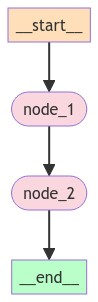

In [10]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(app.get_graph(xray=1).draw_mermaid_png()))

- STATE를 사용하는 이유
- node_2에서 입력값(__start__)를 알아야 할 경우가 생긴다.

- Input: 라스베가스 도시의 현재 온도는? 
  1. 입력 문구에서 도시를 추출한다. -> 라스베가스
  2. 도시로 부터 날씨 정보를 가져온다. -> 외부 API 사용
  3. 날씨 정보로 부터 온도를 가져온다. -> 답변 생성

<img src="./images/CityTemperature.png" width="900">

### References
- [LangGraph - 1. 개요 - 청춘만화](https://normalstory.tistory.com/entry/LangGraph-01)
- [langchain을 공부하며 정리](https://teamsmiley.gitbook.io/devops/ai/langchain/langchain)
  - 랭체인 관련 정리가 잘 되어 있음
- [LangGraph - Multi-Agent Collaboration(다중 협업 에이전트) 로 복잡한 테스크를 수행하는 LLM 어플리케이션 제작 - 테디노트](https://teddylee777.github.io/langgraph/langgraph-multi-agent-collaboration/)
- [Learn LangGraph - The Easy Way](https://www.youtube.com/watch?v=R8KB-Zcynxc)
  - 쉽게 설명하고 있음
- [LangGraph Simple Example](https://www.youtube.com/watch?v=MBhvLHARsyk&t=706s) - [자료 - 종종 서비스가 끊길 수 있음](https://nbviewer.org/github/junji64/LangGraph/blob/main/LangGraph%20-%20Simple%20Example.ipynb)
- [LangGraph: Getting Started: Step by Step tutorial to build Agents : Part1](https://www.youtube.com/watch?v=ny215UUXbhI)


 <img src="./images/LangGraph.png" width="398">

Pregel - 대규모 그래프 처리를 위해 Google에서 개발한 분산 컴퓨팅 프레임워크
- 소셜 네트워크, 웹 그래프, 도로 네트워크등 대규모 그래프 데이트럴 효율적으로 처리하기 위한 용도
- 작동 방식
  - 그래프의 각 노드를 독립적으로 계산
  - 노드들은 서로 메시지를 주고 받으며 정보 교환
  - 각 노드들은 한 단계의 계산을 마치면 다음 단계로 이동
- 특징
  - 수천 대의 컴퓨터에서 동시에 실행될 수 있음
  - 중간에 컴퓨터가 장애가 생겨도 중단없이 실행
  - 프로그래머가 복잡한 분산 시스템을 다루지 않아도 됨
- 응용
  - 페이지랭크 계산, 최단 경로 찾기, 커뮤니티 탐지, 그래프 기반 기계학습